_Version log: trying to apply multi-threading using dask_

In [35]:
import numpy as np
import dask.array as dk #Can make python faster. Numpy is already very fast though.
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import optimize as spopt, fft as spfft #I'm not familiar with cvxpy so I used scipy insted.
from PIL import Image #I prefer Pillow to imageio


For the compressed sensing, I am minimising,
$\mathcal{F} (A)$,
while meeting the condition,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (A) - B = 0,
\end{equation}
where $A$ is the signal that needs to be solved for, $B$ is the sparce signal and $C$ is cropping transformation matrix such that,
\begin{equation}
    C \times A = B.
\end{equation}
$\mathcal{F}( )$ and $I$ are the FFT function and identerty matrix respectively.

In [36]:
iteration_count = 0

def L1_fit(x, y):
    return np.sum(np.abs(y -x))

def DCT_L1_fit(A_DCT, F_prime, B): #DCT of signal, measurement matrix, compressed signal
    B_model = dk.matmul(F_prime, A_DCT)
    B_model = B_model.compute()
    return L1_fit(B, B_model)

def callback_function(x):
    global iteration_count
    iteration_count += 1
    print(iteration_count, end= " ")

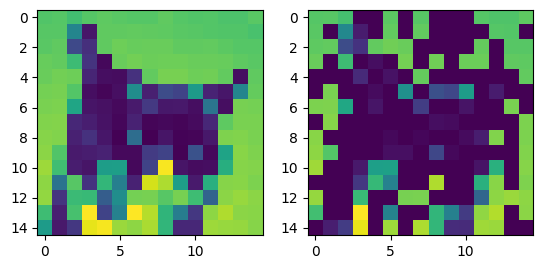

In [37]:
compression = 0.02 #fraction of the image to keep (The image is too large to process quickly)

# original image
img = Image.open('alfie.png') # read image
img = np.array(img).sum(axis=2) # make image grayscale
#A = img[round((1-compression**0.5)/2*img.shape[0]): #very messy way to crop the image
#          round((compression**0.5-1)/2*img.shape[0]) + img.shape[0],
#          round((1-compression**0.5)/2*img.shape[1]):
#          round((compression**0.5-1)/2*img.shape[1]) + img.shape[1],]
A = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
total_points = np.multiply(*A.shape)
A_flat = A.flatten()

# image subsample
subsample = 0.5 #fraction of the image to subsample
random_points = np.random.choice(total_points, round(total_points *subsample), replace= False)
random_points = np.sort(random_points) #Not nessisary but makes it easier to look at.
B_flat = np.zeros(total_points)
B_flat[random_points] = A_flat[random_points]
B_sparce = A_flat[random_points]
B = np.reshape(B_flat, A.shape)

fig, axs = plt.subplots(1,2)

axs[0].imshow(A, interpolation= "nearest")
axs[1].imshow(B, interpolation= "nearest")

plt.show()

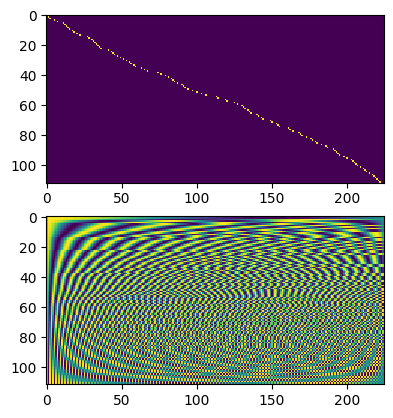

In [38]:
C = np.identity(total_points)
C = C[random_points] #cropping matrix operator

F = spfft.idct(np.identity(total_points), axis= 0)
F_prime = np.matmul(C, F) #THIS IS THE 'MEASUREMENT MATRIX'. Oftern denoted as A.

fig, axs = plt.subplots(2,1)

axs[0].imshow(C, interpolation= "nearest")
axs[1].imshow(F_prime, interpolation= "nearest")

plt.show()

In [39]:
null_vector = np.zeros(total_points, dtype= np.float16) #Scipy has poor support for complex numbers. Pretend that they are all real.

F_prime = dk.array(F_prime)
B_sparce = dk.array(B_sparce)
B_flat = dk.array(B_flat)

In [40]:
########WARNING VERY SLOW!!! (follows Ox^2 where x is the number of pixels)############

iteration_count = 0

opt_result = spopt.minimize(np.linalg.norm, #minimise the norm of the solution
                            x0= B_flat, #initial guess
                            args= (1), #L1 norm
                            callback= callback_function, #count the number of iterations
                            options= {"maxiter": 200}, #max number of iterations. (between 100 and 1000 provides decent convergence)
                            constraints={'type': 'eq', 'fun': DCT_L1_fit, "args":(F_prime, B_sparce)}) #This equation MUST be satisfied. Norm minimisation is secondary!
A_FFT_result = opt_result.x
print(opt_result)

1 2 3 4 5 

KeyboardInterrupt: 

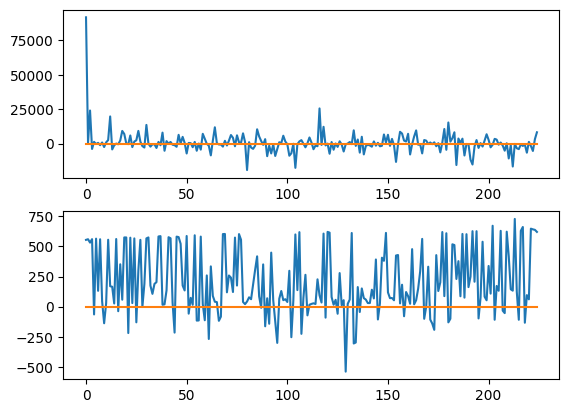

In [ ]:
A_flat_result = spfft.idct(A_FFT_result)

fig, axs = plt.subplots(2,1)

axs[0].plot(np.real(A_FFT_result))
axs[0].plot(np.imag(A_FFT_result))
axs[1].plot(np.real(A_flat_result))
axs[1].plot(np.imag(A_flat_result))

plt.show()

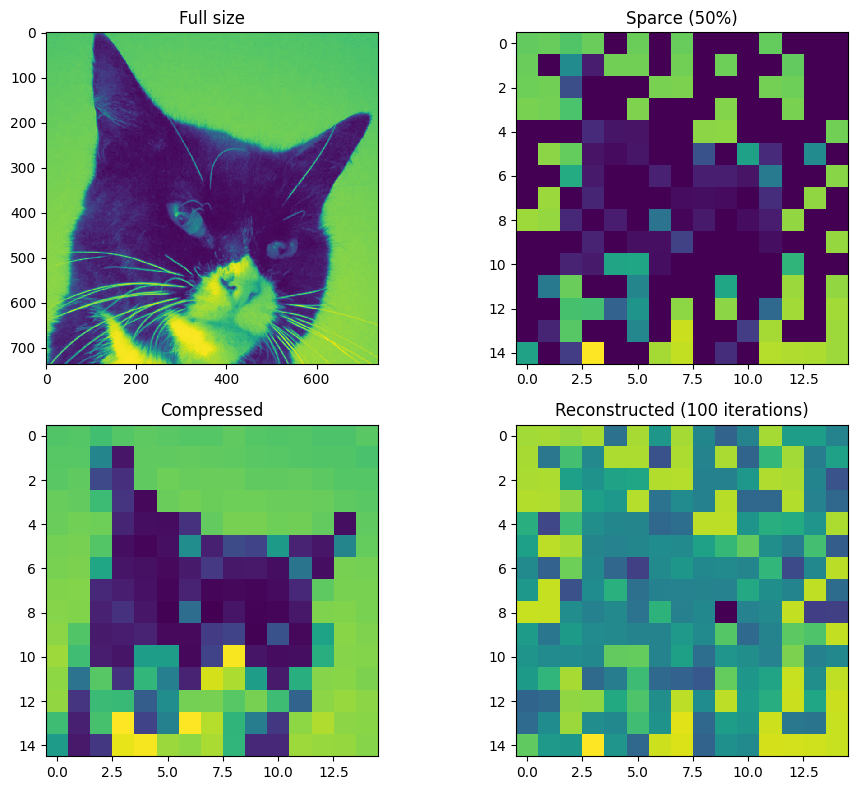

In [ ]:
A_result = np.reshape(A_flat_result, A.shape)
A_result = np.real(A_result)

fig, axs = plt.subplots(2,2, figsize= (10,8))
axs[0][0].imshow(img, interpolation = "nearest")
axs[0][0].set_title("Full size")
axs[1][0].imshow(A, interpolation = "nearest")
axs[1][0].set_title("Compressed")
axs[0][1].imshow(B, interpolation = "nearest")
axs[0][1].set_title("Sparce (50%)")
axs[1][1].imshow(A_result, interpolation = "nearest")
axs[1][1].set_title("Reconstructed (100 iterations)")

plt.tight_layout()
plt.show()